#**Preprocessing Images PlantVillage Dataset**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pytz
from time import time

import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Alignment
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from matplotlib import font_manager
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import psutil
import zipfile


import numpy as np
import tensorflow as tf
import random as rd

**Detail of Python Notebook in Google Colab**

In [ ]:
!nvidia-smi
import subprocess
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print("-------------------------------------------------------------")
print(f"Python {sys.version}")
print("-------------------------------------------------------------")

# ตรวจสอบ GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running on GPU")
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of GPUs Available: {len(gpus)}")

    # ดึงข้อมูล GPU Memory
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        gpu_memory = result.stdout.strip().split('\n')
        for idx, mem in enumerate(gpu_memory):
            print(f"GPU {idx}: Total Memory: {int(mem) / 1024:.2f} GB")
    except FileNotFoundError:
        print("nvidia-smi is not available on this system.")
else:
    print("No GPU detected. Running on CPU")
    strategy = tf.distribute.get_strategy()

# แสดงจำนวนอุปกรณ์ที่พร้อมใช้งาน
print("Number of replicas:", strategy.num_replicas_in_sync)
print("-------------------------------------------------------------")

# แสดงจำนวน RAM ทั้งหมด
total_ram = psutil.virtual_memory().total / (1024 ** 3)
print(f"Total RAM of Colab instance: {total_ram:.2f} GB")
print("-------------------------------------------------------------")

# แสดงเวลาปัจจุบันในเขตเวลาไทย
thailand_tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(thailand_tz).strftime("%Y-%m-%d %H:%M:%S")
print("Current Time (Thailand):", current_time)

Sun Aug 24 13:16:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/projectPlant/Colab')
from my_model import *
from helper_functions import *

Mounted at /content/drive


**Initialize Setting**

In [3]:
root_dir = '/content/drive/MyDrive/projectPlant/'

**SEED**

In [4]:
seeds = [42]
print(seeds)

[42]


**Font Setting**

In [5]:
locations = [f"{root_dir}Extra2/Font"]
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(font_files[0])
for file in font_files:
  font_manager.fontManager.addfont(file)

/content/drive/MyDrive/projectPlant/Extra2/Font/OPTITimes-Roman.otf


**คำอธิบาย**

แบ่ง Data แบบ Fixed Train Validation และ Test ในอัตราส่วน 64:16:20

In [6]:
plant_title = 'PlantVillage Dataset'
plant_dataset_name = 'plantVillageDataset'
plant_dataset_dir = root_dir + plant_dataset_name

In [ ]:
zip_filename = 'plantVillage_dataset_raw.zip'
zip_dir = plant_dataset_dir + '/' + zip_filename
target_folders = [plant_dataset_dir]
with zipfile.ZipFile(zip_dir, "w", zipfile.ZIP_DEFLATED) as zipf:
    for folder in target_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, os.path.dirname(folder)))
print(f'Zip folder complete at {zip_dir}')

Zip folder complete at /content/drive/MyDrive/projectPlant/plantVillageDataset/plantVillage_dataset_raw.zip


In [7]:
plant_img_dir = root_dir + 'Extra2/' + plant_dataset_name
plant_sample_img_dir = plant_img_dir + '/SampleImages'
plant_excel_dir = root_dir + 'DatasetSetting/' + plant_dataset_name + '/'

os.makedirs(plant_img_dir, exist_ok=True)
os.makedirs(plant_sample_img_dir, exist_ok=True)
os.makedirs(plant_excel_dir, exist_ok=True)

**Recheck Path and Verify Images**

In [ ]:
print("Total directories and plantvillage dataset images: \n")
walk_through_dir(plant_dataset_dir)

Total directories and plantvillage dataset images: 

There are 15 directories and 0 images in '/content/drive/MyDrive/projectPlant/plantVillageDataset'.
There are 0 directories and 997 images in '/content/drive/MyDrive/projectPlant/plantVillageDataset/Pepper__bell___Bacterial_spot'.
There are 0 directories and 1478 images in '/content/drive/MyDrive/projectPlant/plantVillageDataset/Pepper__bell___healthy'.
There are 0 directories and 1000 images in '/content/drive/MyDrive/projectPlant/plantVillageDataset/Potato___Early_blight'.
There are 0 directories and 1000 images in '/content/drive/MyDrive/projectPlant/plantVillageDataset/Potato___Late_blight'.
There are 0 directories and 152 images in '/content/drive/MyDrive/projectPlant/plantVillageDataset/Potato___healthy'.
There are 0 directories and 2127 images in '/content/drive/MyDrive/projectPlant/plantVillageDataset/Tomato_Bacterial_spot'.
There are 0 directories and 1000 images in '/content/drive/MyDrive/projectPlant/plantVillageDataset/To

In [ ]:
print("Verifying plantvillage dataset images: \n")
verify_images(plant_dataset_dir)

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
Checking: /content/drive/MyDrive/projectPlant/plantVillageDataset/Tomato__Tomato_YellowLeaf__Curl_Virus/7117a58b-2823-48b2-9cf1-08175711e102___YLCV_NREC 0241.JPG Done
Checking: /content/drive/MyDrive/projectPlant/plantVillageDataset/Tomato__Tomato_YellowLeaf__Curl_Virus/711bb3ff-a4d2-4f24-b8f8-6b5e3cbe6cbd___YLCV_NREC 2822.JPG Done
Checking: /content/drive/MyDrive/projectPlant/plantVillageDataset/Tomato__Tomato_YellowLeaf__Curl_Virus/711f8839-09f1-4ca6-8681-57bba5be4b75___UF.GRC_YLCV_Lab 02646.JPG Done
Checking: /content/drive/MyDrive/projectPlant/plantVillageDataset/Tomato__Tomato_YellowLeaf__Curl_Virus/712b7d19-6c08-4f81-84f9-ec66e39f0de3___UF.GRC_YLCV_Lab 03073.JPG Done
Checking: /content/drive/MyDrive/projectPlant/plantVillageDataset/Tomato__Tomato_YellowLeaf__Curl_Virus/71429702-60e5-4716-a65d-8ff474c67939___YLCV_NREC 2201.JPG Done
Checking: /content/drive/MyDrive/projectPlant/plantVillageDataset/Tomato__Tomato_YellowLeaf__C

**Convert to dataframe**

In [8]:
base_plant_df = to_dataframe(plant_dataset_dir, mode='single', condition=False, labels_mapping=None)

Total images: 20638
Total classes: 15


In [ ]:
print("Base PlantVillage Dataframe \n")
base_plant_df

Base PlantVillage Dataframe 



,Filepath,Label
0,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___Bacterial_spot
1,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___Bacterial_spot
2,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___Bacterial_spot
3,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___Bacterial_spot
4,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___Bacterial_spot
...,...,...
20633,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight
20634,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight
20635,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_healthy
20636,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___healthy


**Description table**

In [ ]:
print(f"{plant_title} description table \n")
plant_summary_df = base_plant_df.groupby('Label').size().reset_index(name='Count')
plant_summary_df

PlantVillage Dataset description table 



,Label,Count
0,Pepper__bell___Bacterial_spot,997
1,Pepper__bell___healthy,1478
2,Potato___Early_blight,1000
3,Potato___Late_blight,1000
4,Potato___healthy,152
5,Tomato_Bacterial_spot,2127
6,Tomato_Early_blight,1000
7,Tomato_Late_blight,1909
8,Tomato_Leaf_Mold,952
9,Tomato_Septoria_leaf_spot,1771


##**Visualize Images**

**Custom Font Size**

In [10]:
import PIL.Image
def visualize_images_by_class(df, nrows=3, ncols=5, title="Title", fontsize=40,
                              fontname="OPTITimes-Roman", image_width=5, image_height=5, paths='/img'):
    '''
    ฟังก์ชันนี้ใช้สำหรับแสดงผลรูปภาพ โดยแสดง Preview 1 ภาพต่อ 1 คลาส
    '''
    class_samples = df.groupby('Label').apply(lambda x: x.sample(1)).reset_index(drop=True)

    count_img = len(class_samples)
    plt.rcParams['font.family'] = fontname

    fig, axes = plt.subplots(
        nrows = nrows,
        ncols = ncols,
        figsize=(ncols * image_width, nrows * image_height),
        subplot_kw = {'xticks': [], 'yticks': []}
    )

    for index, ax in enumerate(axes.flat):
        if index < count_img:
            img = PIL.Image.open(class_samples.Filepath[index])
            ax.imshow(img)
            ax.set_title(class_samples.Label[index], fontsize=fontsize - 4) #<===
        else:
            ax.axis('off')

    fig.text(0.5, 0.0, title, ha='center', fontsize=fontsize+10, fontweight='bold')

    plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
    plt.tight_layout(rect=[0, 0, 0, 0])

    plt.savefig(f"{paths}/Visualize_Images_By_Class", bbox_inches='tight', format='svg', dpi=300)
    plt.show()

In [11]:
visualize_images_by_class(df=base_plant_df, nrows=3, ncols=5, title=plant_title, fontsize=20,
                          fontname="OPTITimes-Roman", image_width=5, image_height=5, paths=plant_sample_img_dir)

Output hidden; open in https://colab.research.google.com to view.

##**Allocate Dataset**

In [ ]:
# วนลูปสำหรับแต่ละ SEED
for seed in seeds:
    print(f"Running experiment with SEED={seed}")
    np.random.seed(seed)

    # แบ่งข้อมูล Train (80%) และ Test (20%)
    train_data, test_data = train_test_split(
        base_plant_df,
        test_size=0.2,
        random_state=seed,
        stratify=base_plant_df['Label']
    )

    # แบ่งข้อมูล Train (64%) และ Validation (16%) จาก Train (80%)
    train_data, val_data = train_test_split(
        train_data,
        test_size=0.2,  # 20% ของ 80% = 16%
        random_state=seed,
        stratify=train_data['Label']
    )

    # เก็บ Original_Index
    train_data['Original_Index'] = train_data.index
    val_data['Original_Index'] = val_data.index
    test_data['Original_Index'] = test_data.index

    # สร้าง DataFrame สำหรับ Train, Validation, Test
    data = {
        'Train_Index': train_data['Original_Index'].tolist(),
        'Train_Paths': train_data['Filepath'].tolist(),
        'Validation_Index': val_data['Original_Index'].tolist(),
        'Validation_Paths': val_data['Filepath'].tolist(),
        'Test_Index': test_data['Original_Index'].tolist(),
        'Test_Paths': test_data['Filepath'].tolist(),
    }

    # เติมข้อมูลให้มีความยาวเท่ากัน
    max_length = max(
        len(data['Train_Paths']),
        len(data['Validation_Paths']),
        len(data['Test_Paths'])
    )

    data['Train_Index'] += [''] * (max_length - len(data['Train_Index']))
    data['Train_Paths'] += [''] * (max_length - len(data['Train_Paths']))
    data['Validation_Index'] += [''] * (max_length - len(data['Validation_Index']))
    data['Validation_Paths'] += [''] * (max_length - len(data['Validation_Paths']))
    data['Test_Index'] += [''] * (max_length - len(data['Test_Index']))
    data['Test_Paths'] += [''] * (max_length - len(data['Test_Paths']))

    # แปลงข้อมูลเป็น DataFrame
    df = pd.DataFrame(data)

    # ตั้งชื่อไฟล์ที่บันทึก
    file_name = f'{plant_excel_dir}split_data_seed_{seed}.xlsx'

    # บันทึกข้อมูลลง Excel
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        df.to_excel(writer, index=False, sheet_name='Split-Data')

        # ปรับขนาดคอลัมน์
        workbook = writer.book
        sheet = workbook['Split-Data']

        for col in sheet.columns:
            max_length = 0
            column = col[0].column_letter  # Get the column letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = max_length + 2
            sheet.column_dimensions[column].width = adjusted_width

        # จัดรูปแบบ header
        header = sheet[1]
        for cell in header:
            cell.alignment = Alignment(horizontal="center", vertical="center")
            cell.font = Font(bold=True)

    print(f"Data split and saved to {file_name}")
    print("--------------------------------------------------")

Running experiment with SEED=42
Data split and saved to /content/drive/MyDrive/projectPlant/DatasetSetting/plantVillageDataset/split_data_seed_42.xlsx
--------------------------------------------------


##**Augmentation Samples Images**

In [ ]:
train_data

,Filepath,Label,Original_Index
5751,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot,5751
2155,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___healthy,2155
16158,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Tomato_YellowLeaf__Curl_Virus,16158
5024,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot,5024
8809,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight,8809
...,...,...,...
9751,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Leaf_Mold,9751
4241,/content/drive/MyDrive/projectPlant/plantVilla...,Potato___Late_blight,4241
7601,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Early_blight,7601
2218,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___healthy,2218


In [ ]:
val_data

,Filepath,Label,Original_Index
15877,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Tomato_YellowLeaf__Curl_Virus,15877
13525,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Spider_mites_Two_spotted_spider_mite,13525
19272,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_healthy,19272
16427,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Tomato_YellowLeaf__Curl_Virus,16427
14005,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Target_Spot,14005
...,...,...,...
14105,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Target_Spot,14105
6432,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot,6432
60,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___Bacterial_spot,60
4523,/content/drive/MyDrive/projectPlant/plantVilla...,Potato___healthy,4523


In [ ]:
SEED=seeds[-1]
np.random.seed(SEED)
tf.random.set_seed(SEED)
rd.seed(SEED)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

train_images = train_generator.flow_from_dataframe(
    dataframe = train_data,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

Found 13208 validated image filenames belonging to 15 classes.


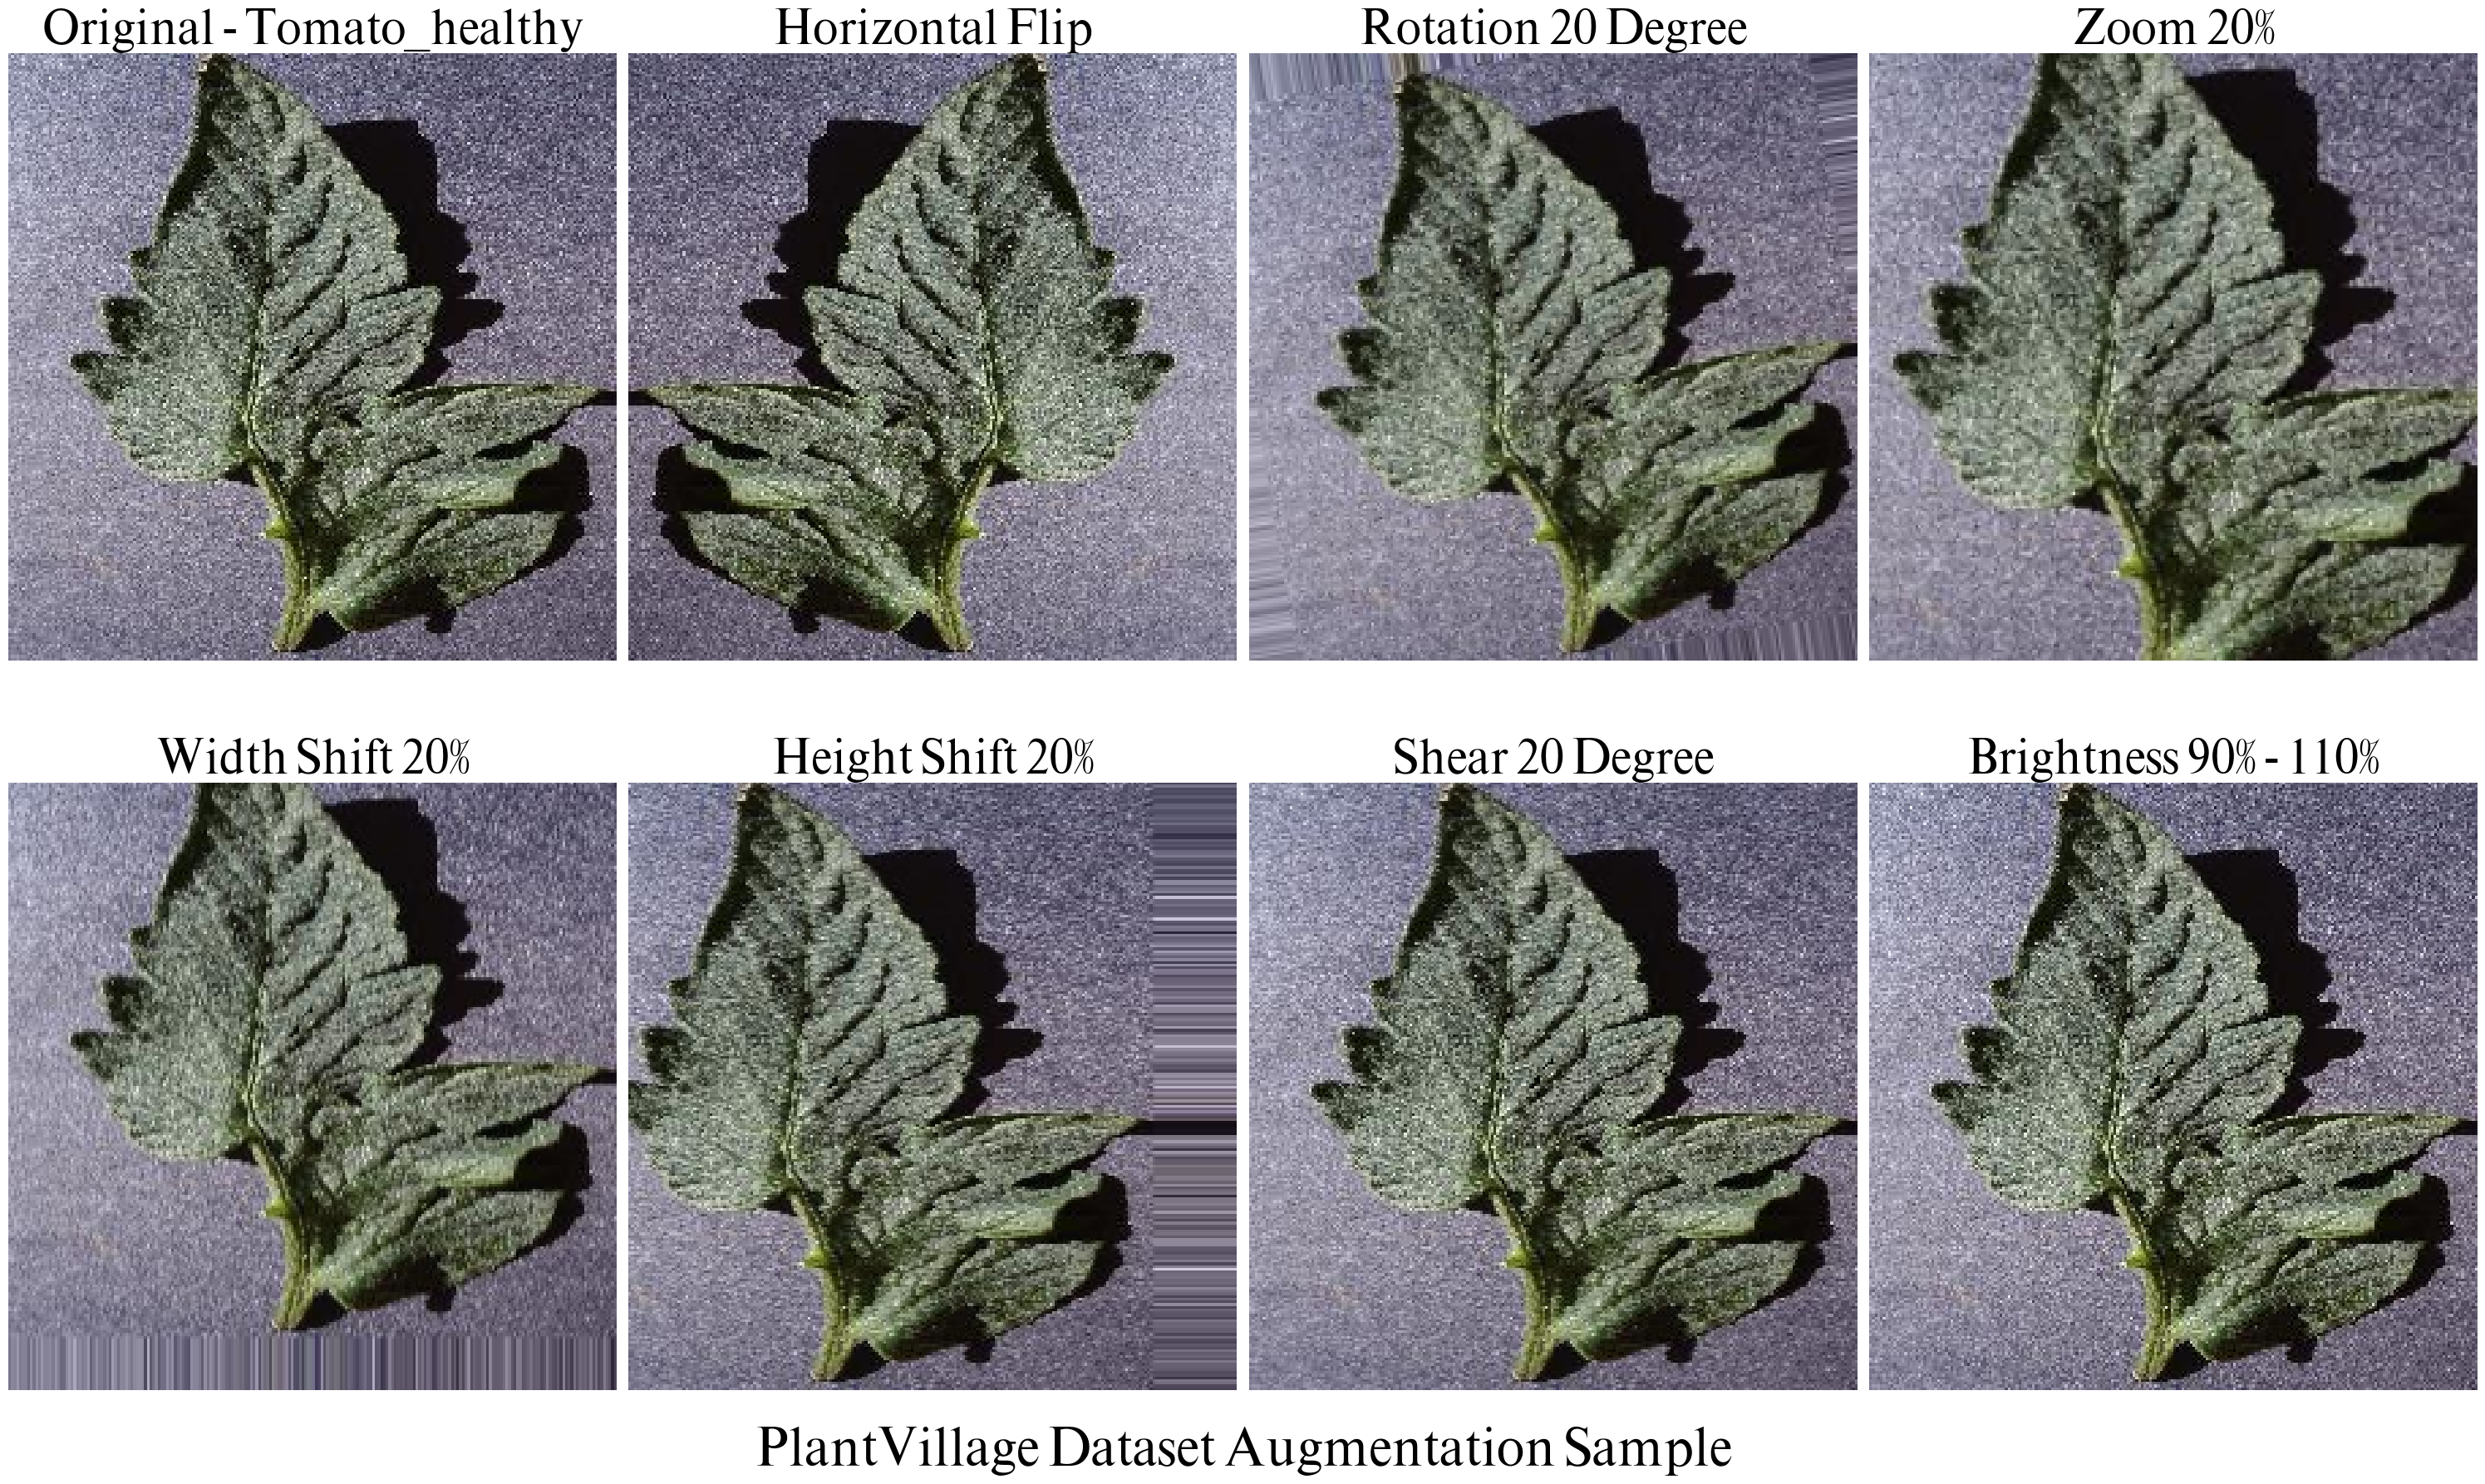

In [ ]:
preview_augmented_images(train_data, title=plant_title, index=16, paths=plant_sample_img_dir)

## **Summary of dataset**

**ส่วนที่รันเพิ่มเติม**

In [ ]:
TRAIN_DF, VALID_DF, TEST_DF = to_dataframe_excel(path="/content/drive/MyDrive/projectPlant/DatasetSetting/plantVillageDataset/split_data_seed_42.xlsx", sheet_name='Split-Data', mode='single', condition=False, labels_mapping=None)

In [ ]:
combined_df = pd.concat([TRAIN_DF, VALID_DF, TEST_DF], axis=0).reset_index(drop=True)
combined_df = combined_df.drop(columns=['Original_Index'])
combined_df

,Filepath,Label
0,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot
1,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___healthy
2,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Tomato_YellowLeaf__Curl_Virus
3,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot
4,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight
...,...,...
20633,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_healthy
20634,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Leaf_Mold
20635,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight
20636,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot


In [ ]:
class_list = combined_df['Label'].unique().tolist()
print(class_list)

total_count = []
train_count = []
val_count = []
test_count = []

for class_name in class_list:
    total_count.append(len(combined_df[combined_df['Label'] == class_name]))
    train_count.append(len(TRAIN_DF[TRAIN_DF['Label'] == class_name]))
    val_count.append(len(VALID_DF[VALID_DF['Label'] == class_name]))
    test_count.append(len(TEST_DF[TEST_DF['Label'] == class_name]))

['Tomato_Bacterial_spot', 'Pepper__bell___healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_healthy', 'Potato___Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Target_Spot', 'Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___healthy']


In [ ]:
summary_df = pd.DataFrame({
    'Class': class_list,
    'Dataset Count': total_count,
    'Train Count': train_count,
    'Validation Count': val_count,
    'Test Count': test_count
})
print(summary_df.to_string(index=False))

                                      Class  Dataset Count  Train Count  Validation Count  Test Count
                      Tomato_Bacterial_spot           2127         1361               340         426
                     Pepper__bell___healthy           1478          945               237         296
      Tomato__Tomato_YellowLeaf__Curl_Virus           3208         2053               513         642
                         Tomato_Late_blight           1909         1222               305         382
Tomato_Spider_mites_Two_spotted_spider_mite           1676         1073               268         335
                             Tomato_healthy           1591         1018               255         318
                       Potato___Late_blight           1000          640               160         200
                  Tomato_Septoria_leaf_spot           1771         1134               283         354
                Tomato__Tomato_mosaic_virus            373          238           

In [ ]:
summary_df.to_excel(plant_excel_dir + 'summary_dataset.xlsx', index=False)